In [1]:
from IPython.display import Image

In [2]:
import pandas as pd

# Datetime Handling

This one is so messy that it gets its own notebook.

Let's start with a csv that has a simple `date` column:

In [3]:
dateCsvPath = 'data/tseries.csv'
print(open(dateCsvPath).read())

2000-01-01,0
2000-01-02,1
2000-01-03,2
2000-01-04,3
2000-01-05,4
2000-01-06,5
2000-01-07,6



### Reading Datetimes as Datetimes

    parse_dates

By default, the parser won't acknowledge the fact that the first column is of type `datetime`.

In [4]:
pd.read_csv(dateCsvPath).dtypes

2000-01-01    object
0              int64
dtype: object

However, you can tell the parser to use the `parse` engine in `dateutil.parser` with the `parse_dates` argument.

In [5]:
pd.read_csv(dateCsvPath, parse_dates=[0], header=None).dtypes

0    datetime64[ns]
1             int64
dtype: object

Simply setting `parse_dates` to True doesn't work, because it only tries to read the index.

In [6]:
pd.read_csv(dateCsvPath, parse_dates=True, header=None).dtypes

0    object
1     int64
dtype: object

## Building Datetimes from multiple columns

    parse_dates
    keep_date_col

Maybe instead, our data csv has 3 columns that make up the same information, but split over month, day, year.

In [7]:
splitDtCsvPath = 'data/tseries3.csv'
print(open(splitDtCsvPath).read())

1,1,2000,0
1,2,2000,1
1,3,2000,2
1,4,2000,3
1,5,2000,4
1,6,2000,5
1,7,2000,6



You can pass a nested list into the `parse_dates` argument to specify which columns make up the date.

In [8]:
pd.read_csv(splitDtCsvPath, header=None, parse_dates=[[0, 1, 2]])

,0_1_2,3
0,2000-01-01,0
1,2000-01-02,1
2,2000-01-03,2
3,2000-01-04,3
4,2000-01-05,4
5,2000-01-06,5
6,2000-01-07,6


And for clarity, you can pass it as a `dict`, and specify a new column name as the key.

In [9]:
pd.read_csv(splitDtCsvPath, header=None, parse_dates={'dateCol':[0, 1, 2]})

,dateCol,3
0,2000-01-01,0
1,2000-01-02,1
2,2000-01-03,2
3,2000-01-04,3
4,2000-01-05,4
5,2000-01-06,5
6,2000-01-07,6


And if you don't want to throw away the existing data, you can specify `keep_date_col=True`

In [10]:
pd.read_csv(splitDtCsvPath, header=None,
            parse_dates={'dateCol': [0, 1, 2]},
            keep_date_col=True)

,dateCol,0,1,2,3
0,2000-01-01,1,1,2000,0
1,2000-01-02,1,2,2000,1
2,2000-01-03,1,3,2000,2
3,2000-01-04,1,4,2000,3
4,2000-01-05,1,5,2000,4
5,2000-01-06,1,6,2000,5
6,2000-01-07,1,7,2000,6


## Tuning Datetime Reads

    date_parser
    infer_datetime_format

The `parser` engine is impressively expressive. However, because it's written to sniff out so many different test cases, it's pretty non-performant at scale in all but the most basic of cases.

Consider a large file (10,000 rows) that looks like

In [11]:
dateTimeCsvPath = 'data/tseries2.csv'
pd.read_csv(dateTimeCsvPath).head()

,DT,ID
0,4/10/17 8:39,3376898277
1,10/3/17 14:41,3390216125
2,4/6/17 8:11,3376630233
3,11/7/17 12:06,3392651569
4,9/5/17 18:17,3388322876


#### Base

Calling `parse_dates` results in the correct typing of the first column.

In [12]:
pd.read_csv(dateTimeCsvPath, parse_dates=[0]).dtypes

DT    datetime64[ns]
ID             int64
dtype: object

But it takes a couple seconds.

In [13]:
%timeit pd.read_csv(dateTimeCsvPath, parse_dates=['DT'])

1.47 s ± 158 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Better

However, if all of the data is going to be of the same format through the whole column, you can use the `infer_datetime_format` argument to run the parser *once* and use that same mapping for the rest of the data.

Negligiblly faster here, but you'd really see the benefits at scale.

In [14]:
%%timeit
pd.read_csv(dateTimeCsvPath, parse_dates=['DT'],
            infer_datetime_format=True)

1.44 s ± 66.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Best

So, if you're trying to parse in some non-intuitive, but consistent, format, you should instead remove the guesswork using the `date_parser` argument.

You want to explicitly define the string mapping using [strftime syntax](http://strftime.org/) and `pd.to_datetime`.

In [15]:
%%timeit 
ourFormat = '%m/%d/%y %H:%M'
pd.read_csv(dateTimeCsvPath, parse_dates=['DT'],
            date_parser=lambda x: pd.to_datetime(x, format=ourFormat))

44.5 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Much** better

## Data from other locales

    dayfirst

In much the same way as decimals and commas in large numbers, other, less-enlightened parts of the world don't follow our superior date formatting

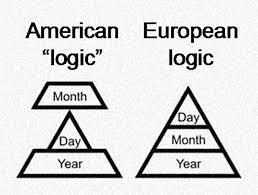

In [16]:
Image('data/pyramid.png')

So, you can handle for this backwards convention using the `dayfirst` argument.